In [2]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime
import joblib

import boto3
import sagemaker
from sagemaker.model import Model
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter, HyperparameterTuner
from tqdm import tqdm

import numpy as np
import pandas as pd
from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from src.train_entry import TSTrainer

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='forecast')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

In [4]:
s3 = boto3.client('s3')

raw_data_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/raw-data'

train_val_test_path = {
    'train': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
    'test': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test'
}
train_val_test_path, raw_data_path

({'train': 's3://elo-ml-sagemaker/forecast-project/input-data/train',
  'test': 's3://elo-ml-sagemaker/forecast-project/input-data/test'},
 's3://elo-ml-sagemaker/forecast-project/raw-data')

In [5]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
ecr_boto3 = boto3.client('ecr')
lambda_boto3 = boto3.client('lambda')
iam_boto3 = boto3.resource('iam')
apigateway_boto3 = boto3.client('apigateway')
role = sagemaker.get_execution_role()

In [6]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if 'imageTag' in ecr_meta_data_dict and ecr_meta_data_dict['imageTag'].startswith('preprocess'):
        preprocess_image_tag = ecr_meta_data_dict['imageTag']

preprocess_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{preprocess_image_tag}'

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:275: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


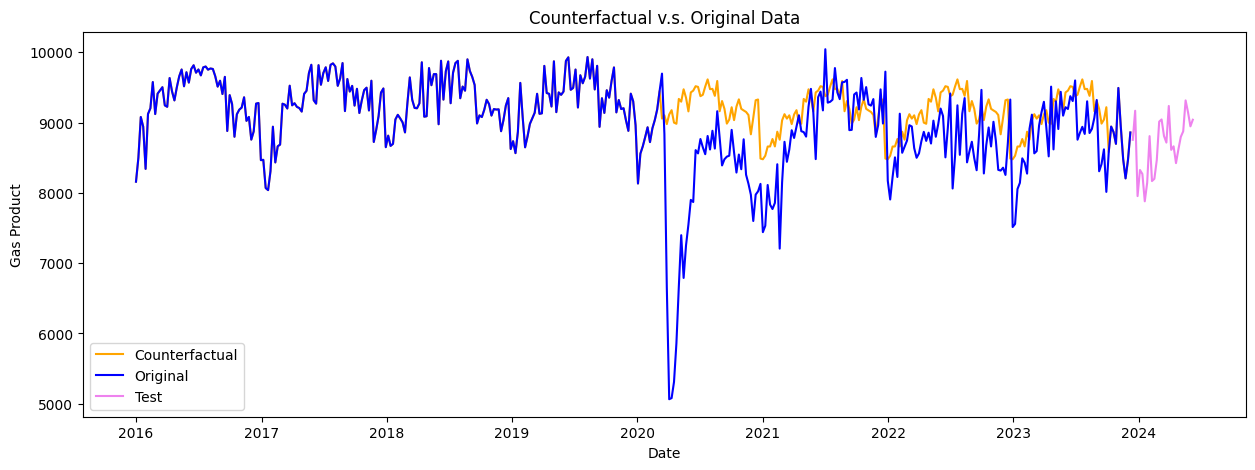

In [11]:
train = pd.read_csv(os.path.join(train_val_test_path['train'], 'train.csv'), index_col=0)
train.index = pd.to_datetime(train.index)
train.index.freq = config['freq']
test = pd.read_csv(os.path.join(train_val_test_path['test'], 'test.csv'), index_col=0)
test.index = pd.to_datetime(test.index)
test.index.freq = config['freq']

fig, ax = plt.subplots(figsize=(15, 5))
# Plot original data
ax.plot(train.loc ['2016':'2023']['gas_product_forecast'], label='Counterfactual', color='orange')
ax.plot(train.loc['2016':'2023']['gas_product'], label='Original', color='blue')
ax.plot(test['gas_product'], label='Test', color='violet')
ax.set_xlabel('Date')
ax.set_ylabel('Gas Product')
ax.set_title('Counterfactual v.s. Original Data')
plt.legend(loc='best')
plt.show()

In [28]:
!aws s3 cp s3://elo-ml-sagemaker/forecast-project/models/tuning-job-240617-0000-004-9516f5ed/output/model.tar.gz /tmp/model_artifacts.tar.gz
# The options -x = extract files from the archive, -z = uncompress the archive with gzip, -f = use archive file, and -C = change directory to the specified directory
!tar -xzf /tmp/model_artifacts.tar.gz -C /tmp

download: s3://elo-ml-sagemaker/forecast-project/models/tuning-job-240617-0000-004-9516f5ed/output/model.tar.gz to ../../../../../tmp/model_artifacts.tar.gz
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'


In [12]:
model_full = joblib.load('/tmp/model_full_target_pipeline.joblib')
fourier_transformer_full = joblib.load('/tmp/model_full_fourier_transformer.joblib')

model_train = joblib.load('/tmp/model_train_target_pipeline.joblib')
fourier_transformer_train = joblib.load('/tmp/model_train_fourier_transformer.joblib')

In [13]:
y_train = train['gas_product_forecast'].copy()
y_train.index = pd.PeriodIndex(y_train.index, freq=config['freq'])

y_test = test['gas_product'].copy()
y_test.index = pd.PeriodIndex(y_test.index, freq=config['freq'])

y_full = pd.concat([y_train, y_test], axis=0)

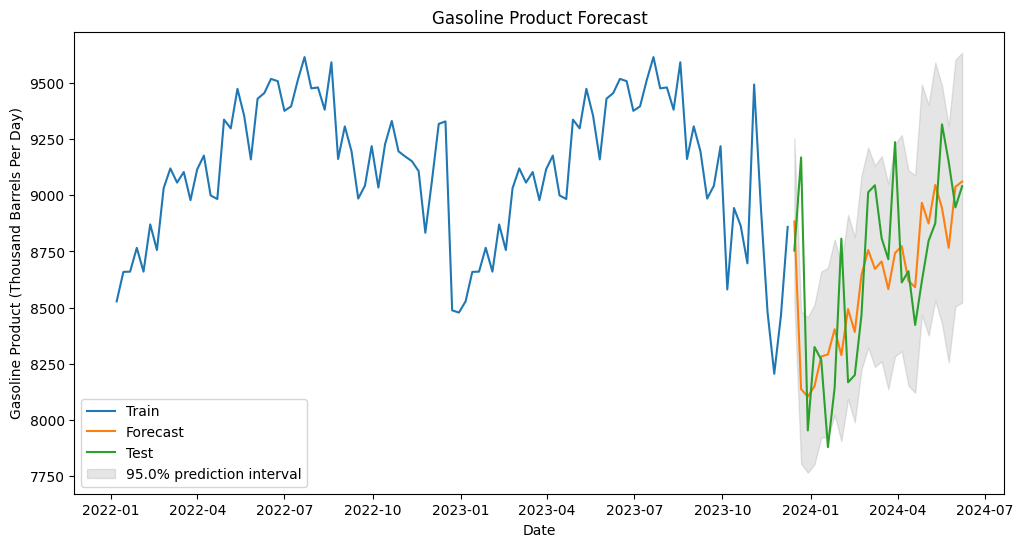

In [14]:
TSTrainer.plot_forecast(
    target_pipeline=model_train,
    fourier_transformer=fourier_transformer_train,
    y_train=y_train,
    y_test=y_test,
    conf=config['conf'],
    forecast_horizon=config['forecast_horizon'],
    start_date='2022-01-01'
)

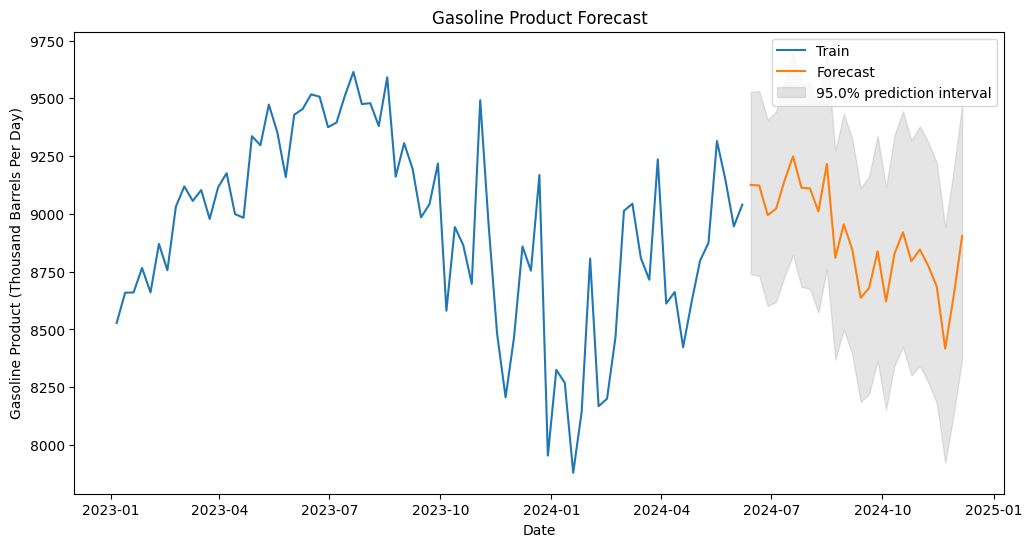

In [15]:
TSTrainer.plot_forecast(
    target_pipeline=model_full,
    fourier_transformer=fourier_transformer_full,
    y_train=y_full,
    y_test=None,
    conf=config['conf'],
    forecast_horizon=config['forecast_horizon'],
    start_date='2023-01-01'
)